# PREPROCESS DATA FOR MODELS
Allow models to load pickle files to preserve memory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Jupiter  MacOS
# BASE_DIR = "/Users/johnhanratty/Library/CloudStorage/OneDrive-Personal/IRMA_GIT/Kaggle_SignLanguage/asl-signs"
# WORKING_DIR = BASE_DIR
# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
WORKING_DIR = "/content/asl-work"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working/"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 64 #16 # 16
PTS_IN_FRAME = 115
DIMC = [0,1,2]
DIMS = len(DIMC)

  
HANDIDX = {"WRIST":0, "THUMB_CMC":1, "THUMB_MCP":2,     "THUMB_IP":3,          "THUMB_TIP":4,
        "INDEX_FINGER_MCP":5, "INDEX_FINGER_PIP":6,  "INDEX_FINGER_DIP":7,  "INDEX_FINGER_TIP":8,
        "MIDDLE_FINGER_MCP":9,"MIDDLE_FINGER_PIP":10,"MIDDLE_FINGER_DIP":11,"MIDDLE_FINGER_TIP":12,
        "RING_FINGER_MCP":13, "RING_FINGER_PIP":14,  "RING_FINGER_DIP":15,  "RING_FINGER_TIP":16,
        "PINKY_FINGER_MCP":17,"PINKY_FINGER_PIP":18,  "PINKY_FINGER_DIP":19,"PINKY_FINGER_TIP":20}

POSEIDX = {"NOSE":0,        "LEFT_EYE_INNER":1,"LEFT_EYE":2,   "LEFT_EYE_OUTER":3, "RIGHT_EYE_INNER":4, "RIGHT_EYE":5,      "RIGHT_EYE_OUTER":6,
        "LEFT_EAR":7,    "RIGHT_EAR":8,     "MOUTH_LEFT":9, "MOUTH_RIGHT":10,   "LEFT_SHOULDER":11,  "RIGHT_SHOULDER":12,
        "LEFT_ELBOW":13, "RIGHT_ELBOW":14,  "LEFT_WRIST":15, "RIGHT_WRIST":16, 
        "LEFT_PINKY":17, "RIGHT_PINKY":18,  "LEFT_INDEX":19,"RIGHT_INDEX":20,   "RIGHT_THUMB":21,    "LEFT_THUMB":22,
        "LEFT_HIP":23,   "RIGHT_HIP":24,    "LEFT_KNEE":25, "RIGHT_KNEE":26,    "LEFT_ANKLE":27,     "RIGHT_ANKLE":28,
        "LEFT_HEEL":29,  "RIGHT_HEEL":30,   "LEFT_FOOT_INDEX":31, "RIGHT_FOOT_INDEX":32}

LIPSIDX = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
LIPSIDX_sm = [185, 39, 0,  269,  409,  78,  80,  82,  312,  310,  308,  88,  87,  317,  318,  146,  181,  17,  405, 375]


# need to rerun parquet processing to grab data points
#LIPSIDX1 = [12, 268,271,272,407, 293, 325,319,403,316,15,86,179,89,96,62, 183,42,41,38]

METALEN = len(LIPSIDX) + len(POSEIDX) + 2 * len(HANDIDX)

def PRIM_HAND(idx): return(40 + HANDIDX[idx])
def POSE(idx):  return(40 + 21 + POSEIDX[idx])
def SEC_HAND(idx):  return(40 + 21 + 33 + HANDIDX[idx])

print(POSE("NOSE"))
print(SEC_HAND("WRIST"))
METALEN

print('done')


61
94
done


In [3]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



In [4]:
# PREPOCESS-A  - FRAMES OUTPUT
import psutil

def preProc(MIRROR=True):
  dx = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
  datay = np.load(f"{WORKING_DIR}/feature_labels.npy") 

  data_rows = dx.shape[0]

  print("DX BASE", dx.base)   #BASE1 ROOT READ FROM FILE
  print("dx shape", dx.shape)
  # MAKE COPY OF DX1 input from file
  dx = dx.reshape((data_rows, FRAMES_OUT, -1, 3))  # BASE 1
  print("DX BASE", dx.base[0,0,0]) 

  # DEFINE VIEW MATRICES 
  start_lips =  0
  start_left =  PRIM_HAND("WRIST")
  start_pose =  POSE("NOSE")
  start_right = SEC_HAND("WRIST")
  end_right =   METALEN

  lips_3d =   dx[:, :, 0:PRIM_HAND("WRIST"), :]
  lefth_3d =  dx[:, :, PRIM_HAND("WRIST"):POSE("NOSE"), :]
  pose_3d =   dx[:, :, POSE("NOSE"):SEC_HAND("WRIST"),:]
  righth_3d = dx[:, :, SEC_HAND("WRIST"):METALEN, :]   # BASE1
  print("BASE RIGHT", righth_3d.base[0,0,0])

  # Combind Componets to dx
  dx=np.concatenate((lips_3d, lefth_3d, pose_3d, righth_3d), axis=2)  ## COPY
  print("CONCATX BASE", dx.base)  # BASE2 ROOT
  
  split_bar = '='*20
  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  #MIRROR = False
  if MIRROR: 
      # Mirror data on x-axis (max-value)
      lips_m = lips_3d
      lips_m[:,:,:,0] = np.nanmax(lips_3d[:,:,:,0]) - lips_3d[:,:,:,0]
      left_m = lefth_3d
      left_m[:,:,:,0] = np.nanmax(lefth_3d[:,:,:,0]) - lefth_3d[:,:,:,0]
      pose_m = pose_3d
      pose_m[:,:,:,0] = np.nanmax(pose_3d[:,:,:,0]) - pose_3d[:,:,:,0]
      right_m = righth_3d
      print("RIGHT_M BASE1", right_m.base[0,0,0])
      right_m[:,:,:,0] = np.nanmax(righth_3d[:,:,:,0]) - righth_3d[:,:,:,0]
      print("RIGHT_M BASE2", right_m.base[0,0,0])

      # NOTE: reversed and swapped position of left_m and right_m 
      # so last slot is primary hand
      datam = np.concatenate((lips_m, right_m, pose_m, left_m), axis=2)
      print("DATAM", datam.shape)

      # find primary hand (Count NaNs)
      #  -check whether lefth_3d OR righth_3d has more NaNs
      cl = lefth_3d.reshape(lefth_3d.shape[0],-1)
      cr = righth_3d.reshape(lefth_3d.shape[0],-1)
      cc = np.isnan(cl).sum(axis=1) > np.isnan(cr).sum(axis=1)
      dx[cc,:,:,:] = datam[cc,:,:,:]  # replace 

  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  # REPLACE NaNs
  print('DX NANS FOR REPLACEMENT', np.isnan(dx).sum())
  #dx = np.nan_to_num(dx, copy=False)

  # SET 3D or 2D (SELECT dim columns)
  print(dx.shape)
  if DIMS !=3:
    dx = datax[:,:,:,DIMC]

  print("FINAL SHAPE")
  print("dx", dx.shape)
  print("datay", datay.shape)
  return(dx, datay)

# FINAL SHAPE separate line for seq and feature




In [5]:
from sklearn.decomposition import PCA


def pca_convert(dx, COMPONENTS = 60):
    dx = np.nan_to_num(dx, copy=False)
    shp = dx.shape
    pca_X = PCA(n_components=COMPONENTS, random_state=999) 
    pca_X.fit(dx.reshape(shp[0]*shp[1], -1))
    dx = pca_X.transform(dx.reshape(shp[0]*shp[1],-1))
    dx = dx.reshape(shp[0], shp[1], -1)
    print(dx.shape,"Components=", COMPONENTS)
    print(np.cumsum(pca_X.explained_variance_ratio_ *100))
    return(dx)


## 3D with Mirrored Primary Hands
47GB RAM  of 83.5GB

In [8]:
#3D XYZ MIRROR PRIMARY  w/ PCA
datax, datay = preProc()
np.save(f"{WORKING_DIR}/feature_prep64npca.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64npca.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64npca.npy")

datax = pca_convert(datax,90)
np.save(f"{WORKING_DIR}/feature_prep64.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64.npy")





DX BASE None
dx shape (94477, 64, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639665664
available 36603068416
percent 59.2
used 52123246592
free 2839818240
active 1316683776
inactive 84425502720
buffers 353312768
cached 34323288064
shared 1495040
slab 603914240
RIGHT_M BASE1 0.5158617496490479
RIGHT_M BASE2 0.5158617496490479
DATAM (94477, 64, 115, 3)
==================== Memory Usage ====================
total 89639665664
available 13785362432
percent 84.6
used 74939240448
free 10736082944
active 1316827136
inactive 76644364288
buffers 348946432
cached 3615395840
shared 1503232
slab 454762496
DX NANS FOR REPLACEMENT 1396975620
(94477, 64, 115, 3)
FINAL SHAPE
dx (94477, 64, 115, 3)
datay (94477,)
(94477, 64, 90) Components= 90
[79.05452167 92.71848969 95.39405354 96.64284371 97.68225876 98.46172909
 98.85461573 99.07449185 99.27949411 99.43927504 99.53345624 99.60327188
 99.67060959 99.72

'/content/drive/MyDrive/GaggleSignLang/feature_prep64.npy'

In [7]:
#3D XYZ MIRROR PRIMARY NO PCA
datax, datay = preProc()
#datax = pca_convert(datax,90)
np.save(f"{WORKING_DIR}/feature_prep64npca.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64npca.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64npca.npy")



DX BASE None
dx shape (94477, 64, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639665664
available 36601905152
percent 59.2
used 52131414016
free 2744803328
active 1083670528
inactive 84587139072
buffers 356958208
cached 34406490112
shared 1490944
slab 766672896
RIGHT_M BASE1 0.5158617496490479
RIGHT_M BASE2 0.5158617496490479
DATAM (94477, 64, 115, 3)
==================== Memory Usage ====================
total 89639665664
available 13776777216
percent 84.6
used 74952957952
free 10917376000
active 1070972928
inactive 76675227648
buffers 356417536
cached 3412914176
shared 1490944
slab 475856896
DX NANS FOR REPLACEMENT 1396975620
(94477, 64, 115, 3)
FINAL SHAPE
dx (94477, 64, 115, 3)
datay (94477,)


'/content/drive/MyDrive/GaggleSignLang/feature_prep64npca.npy'

##NO MIRRORING 3D
48GB Memory Used

In [ ]:
#3D XYZ ***NO MIRROR** PRIMARY
datax, datay = preProc(False)
datax = pca_convert(datax,90)
np.save(f"{WORKING_DIR}/feature_prep64nm.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64nm.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64nm.npy")



DX BASE None
dx shape (94477, 64, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639657472
available 53422448640
percent 40.4
used 35316645888
free 11710361600
active 1074544640
inactive 75042029568
buffers 363692032
cached 42248957952
shared 1429504
slab 1431961600
==================== Memory Usage ====================
total 89639657472
available 53422448640
percent 40.4
used 35316645888
free 11710361600
active 1074544640
inactive 75042029568
buffers 363692032
cached 42248957952
shared 1429504
slab 1431961600
DX NANS FOR REPLACEMENT 1396975620
(94477, 64, 115, 3)
FINAL SHAPE
dx (94477, 64, 115, 3)
datay (94477,)
(94477, 64, 90) Components= 90
[81.77506759 90.34655017 92.47916253 94.29823209 96.06392483 97.23677124
 97.9647071  98.35995422 98.73353398 98.95890178 99.15904268 99.29888298
 99.41306078 99.51905125 99.60400856 99.66167202 99.70726431 99.74307051
 99.77232553 99.79605363 99.81802

'/content/drive/MyDrive/GaggleSignLang/feature_prep64nm.npy'

## 2D XY with Mirrored Primary Hand

In [ ]:
# 2D xy MIRROR PRIMARY
datax = datax, datay = preProc()
datax = datax.reshape(datax.shape[0], datax.shape[1], -1, 3)
datax = pca_convert(datax[:,:,:,[0,1]],70)
np.save(f"{WORKING_DIR}/feature_prep64xy.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64xy.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64xy.npy")


DX BASE None
dx shape (94477, 64, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639657472
available 53707177984
percent 40.1
used 35029540864
free 3132985344
active 3721895936
inactive 81275346944
buffers 364232704
cached 51112898560
shared 1912832
slab 1176195072
RIGHT_M BASE1 0.5158617496490479
RIGHT_M BASE2 0.5158617496490479
DATAM (94477, 64, 115, 3)
==================== Memory Usage ====================
total 89639657472
available 30875480064
percent 65.6
used 57861369856
free 11843674112
active 3724705792
inactive 72935124992
buffers 364089344
cached 19570524160
shared 1916928
slab 761647104
DX NANS FOR REPLACEMENT 1396975620
(94477, 64, 115, 3)
FINAL SHAPE
dx (94477, 64, 115, 3)
datay (94477,)
(94477, 64, 70) Components= 70
[82.35040149 95.4884134  98.74063235 99.02126732 99.2430226  99.42044468
 99.56484751 99.67154414 99.7519021  99.81656173 99.85299175 99.88412712
 99.9080423  99.

'/content/drive/MyDrive/GaggleSignLang/feature_prep64xy.npy'

## 2D XZ Mirrored Primary Hand

In [ ]:
# 2D - XZ MIRROR PRIMARY
datax, datay = preProc()
datax = datax.reshape(datax.shape[0], datax.shape[1], -1, 3)
datax = pca_convert(datax[:,:,:,[0,2]],70)
np.save(f"{WORKING_DIR}/feature_prep64xz.npy", datax)
shutil.copy(f"{WORKING_DIR}/feature_prep64xz.npy", f"/content/drive/MyDrive/GaggleSignLang/feature_prep64xz.npy")


DX BASE None
dx shape (94477, 64, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639665664
available 36379770880
percent 59.4
used 52335452160
free 2489679872
active 1665933312
inactive 84534501376
buffers 42024960
cached 34772508672
shared 1568768
slab 576892928
RIGHT_M BASE1 0.5158617496490479
RIGHT_M BASE2 0.5158617496490479
DATAM (94477, 64, 115, 3)
==================== Memory Usage ====================
total 89639665664
available 13555564544
percent 84.9
used 75159949312
free 10612334592
active 1682935808
inactive 76492365824
buffers 38694912
cached 3828686848
shared 1568768
slab 436346880
DX NANS FOR REPLACEMENT 1396975620
(94477, 64, 115, 3)
FINAL SHAPE
dx (94477, 64, 115, 3)
datay (94477,)
(94477, 64, 70) Components= 70
[82.30743723 93.39722743 95.74271908 97.11634531 98.35042216 98.87268955
 99.35083151 99.54768793 99.64565327 99.70770784 99.75020655 99.78569183
 99.82012617 99.8518

'/content/drive/MyDrive/GaggleSignLang/feature_prep64xz.npy'

In [ ]:
#datax = np.load(f"/content/drive/MyDrive/GaggleSignLang/feature_prep64.npy")
dx = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
dy = np.load(f"{WORKING_DIR}/feature_labels.npy") 

# Figure out #frames in videos

In [ ]:
dd = dx.reshape(dx.shape[0], dx.shape[1], -1, 3)[:,:,0,0]

NameError: ignored

In [ ]:
print(dx.shape)
nan_ct = dx.reshape(dx.shape[0], dx.shape[1], -1, 3)[:,:,0,0]
nan_ct = np.nansum(~np.isnan(nan_ct), axis=1)
dss = pd.DataFrame({'truth':dy, 'nans':nan_ct})
dss.head()

(94477, 64, 345)


,truth,nans
0,25.0,23
1,232.0,11
2,48.0,52
3,23.0,12
4,164.0,18


In [ ]:
# LOAD POLYGON DATA - FRAMES
import pickle

with open(f"/content/drive/MyDrive/GaggleSignLang/truth_nan.pkl", 'wb') as handle:
       pickle.dump(dss, handle)


(array([12314., 12722., 16978., 11362.,  7846.,  6156.,  4244.,  4889.,
         5016., 12950.]),
 array([ 0. ,  6.4, 12.8, 19.2, 25.6, 32. , 38.4, 44.8, 51.2, 57.6, 64. ]),
 <BarContainer object of 10 artists>)

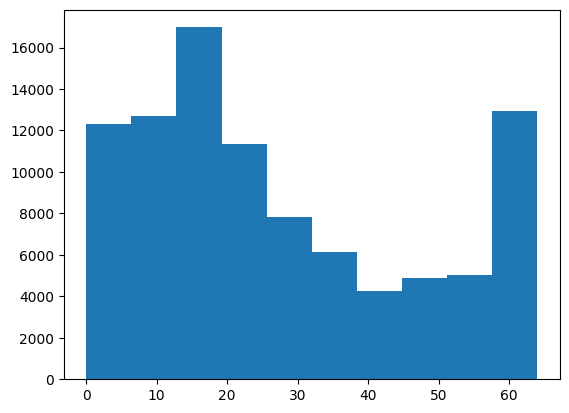

In [ ]:
import matplotlib.pyplot as plt
nan_ct.shape
plt.hist(nan_ct, bins=10)